# iLQG algorithm with inverted Pendulum

## Initialize variables

In [1]:
import numpy as np
from drl.ilqg import Pendulum

In [2]:
env = Pendulum()

render_env = True

T = 100
dt = 0.05
state_dim = 2
action_dim = 1

epsilon = 1e-8
lamb = 1.0
lamb_factor = 10
lamb_max = 1000
eps_converge = 1e-3

## Helper functions
Define functions for calculating temporal difference derivative and losses.

### Only valid for pendulum environment!

In [3]:
def dynamics(x, u):
    th, thdot = x

    g = 10.
    m = 1.
    l = 1.
    dt = 0.05
    max_torque = 8.
    max_speed = 2.
        
    u = np.clip(u, -max_torque, max_torque)[0]

    newthdot = thdot + (-3 * g / (2 * l) * np.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
    newth = th + newthdot * dt
    newthdot = np.clip(newthdot, -max_speed, max_speed)

    return np.array([newth, newthdot])

In [4]:
def dynamics_derivatives(t, epsilon):
    x, u = t

    dfdx = []
    for i in range(len(x)):
        x_plus = np.copy(x)
        x_plus[i] += epsilon
        x_min = np.copy(x)
        x_min[i] -= epsilon
        dfdx.append((dynamics(x_plus, u) - dynamics(x_min, u)) / (2. * epsilon))

    dfdu = []
    for i in range(len(u)):
        u_plus = np.copy(u)
        u_plus[i] += epsilon
        u_min = np.copy(u)
        u_min[i] -= epsilon
        dfdu.append((dynamics(x, u_plus) - dynamics(x, u_min)) / (2. * epsilon))
        
    return np.stack(dfdx, axis=1), np.stack(dfdu, axis=1)

In [5]:
def calc_cost(t):
#     x, u = t
#     l = 0.01 * u**2
#     lx = np.zeros([2, 1])
#     lu = 0.02 * u
#     lxx = np.zeros([2, 2])
#     luu = 0.02
#     lux = np.zeros(2)
#     return l, lx, lu, lxx, luu, lux
    x, u = t
    l = (1 - np.cos(x[0]))**2 + 0.1 * x[1]**2 + 0.01 * u**2
    lx = np.array([2.*(1. - np.cos(x[0]))*np.sin(x[0]), 0.2*x[1]]).reshape([2, 1])
    lu = 0.02 * u
    lxx = np.array([4.*np.sin(x[0]/2.)**2 * (2*np.cos(x[0]) + 1), 0., 0., 0.2]).reshape([2, 2])
    luu = 0.02
    lux = 0.
    return l, lx, lu, lxx, luu, lux

def calc_final_cost(t):
    x, u = t
    l = (1 - np.cos(x[0]))**2 + 0.1 * x[1]**2 + 0.01 * u**2
    lx = np.array([2.*(1. - np.cos(x[0]))*np.sin(x[0]), 0.2*x[1]]).reshape([2, 1])
    lu = 0.02 * u
    lxx = np.array([4.*np.sin(x[0]/2.)**2 * (2*np.cos(x[0]) + 1), 0., 0., 0.2]).reshape([2, 2])
    luu = 0.02
    lux = 0.
    return l, lx, lu, lxx, luu, lux

## Forward pass
Execute control sequence pi. Calculate dynamics derivatives and loss (derivatives for every step). Return derivatives and total loss.

In [6]:
def forward_pass(pi):    
    trajectory = []
    derivatives = []
    cost = 0.
    
    x = env.reset()
    
    # Execute all steps except for final step
    for i in range(T-1):
        if render_env:
            env.render()

        u = pi[i]
                
        # Calculate dyanmics derivatives and loss (derivatives)
        seq = (x, u)
        dfdx, dfdu = dynamics_derivatives(seq, epsilon)
        l, lx, lu, lxx, luu, lux = calc_cost(seq)
        
        cost += l
        
        # Store values
        derivatives.append((np.eye(state_dim) + dfdx*dt, dfdu*dt, lx*dt, lu*dt, lxx*dt, luu*dt, lux*dt))
        trajectory.append(x)
        
        # Execute action
        x = env.step(u)
        
    if render_env:
        env.render(close=True)
        
    # Add final time step
    seq = (x, np.zeros(1))
    
    dfdx, dfdu = dynamics_derivatives(seq, epsilon)
    l, lx, lu, lxx, luu, lux = calc_final_cost(seq)
        
    cost += l
    
    derivatives.append((np.eye(state_dim) + dfdx*dt, dfdu*dt, lx*dt, lu*dt, lxx*dt, luu*dt, lux*dt))
    trajectory.append(x)
    
    return trajectory, derivatives, cost

Test forward pass with random control sequence for T steps, print first 10 samples of trajectory to check if values are correct.

In [7]:
pi = np.random.randn(T, 1)
trajectory, derivatives, cost = forward_pass(pi)

print 'Trajectory: ', trajectory[:5]
print 'Derivatives: ', derivatives[:2]
print 'Cost: ', cost

Trajectory:  [array([ 0.,  0.]), array([-0.00175713, -0.03514265]), array([-0.00035021,  0.02813839]), array([ 0.00455818,  0.09816795]), array([ 0.02463751,  0.40158657])]
Derivatives:  [(array([[ 1.051875,  0.0025  ],
       [ 0.0375  ,  1.05    ]]), array([[ 0.000375],
       [ 0.0075  ]]), array([[ 0.],
       [ 0.]]), array([-0.00023428]), array([[ 0.  ,  0.  ],
       [ 0.  ,  0.01]]), 0.001, 0.0), (array([[ 1.051875  ,  0.0025    ],
       [ 0.03749994,  1.05      ]]), array([[ 0.000375],
       [ 0.0075  ]]), array([[ -2.71258443e-10],
       [ -3.51426516e-04]]), array([ 0.00043066]), array([[  4.63126641e-07,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e-02]]), 0.001, 0.0)]
Cost:  [ 251.58068]


## Backward pass

For final timestep $T$

$V(x,T) = l_f(x_T)$

Now iterate backwards from timestep $t = T$ to $t = 0$. Calculate $Q$-values using:

$Q_x = l_x + f_x^TV'_x\\
Q_u = l_u + f_u^TV'_x\\
Q_{xx} = l_{xx} + f_x^TV'_{xx}f_x\\
Q_{uu} = l_{uu} + f_u^TV'_{xx}f_u\\
Q_{ux} = l_{ux} + f_u^TV'_{xx}f_x$

From the $Q$-values we can derive the $V$-values and control modifications $K$, $k$

$K = -Q_{uu}^{-1}Q_{ux}\\
k = -Q_{uu}^{-1}Q_{u}$

$V_x = Q_x - K^TQ_{uu}k\\
V_{xx} = Q_{xx} - K^TQ_{uu}K$


Derivative sequence is $(f_x, f_u, l_x, l_u, l_{xx}, l_{uu}, l_{ux})$

In [8]:
def backward_pass(derivatives, lamb):
    K = []
    k = []
    
    Vx = derivatives[T-1][2]
    Vxx = derivatives[T-1][4]
    
    for i in reversed(range(T-1)):
        der = derivatives[i]
        Qx = der[2] + np.dot(der[0].T, Vx)        
        Qu = der[3] + np.dot(der[1].T, Vx)
        Qxx = der[4] + np.dot(der[0].T, np.dot(Vxx, der[0]))
        Quu = der[5] + np.dot(der[1].T, np.dot(Vxx, der[1]))
        Qux = der[6] + np.dot(der[1].T, np.dot(Vxx ,der[0]))
        
        U, S, V = np.linalg.svd(Quu)
        S[S < 0] = 0.0
        S += lamb
        Quu_inv = np.dot(U, np.dot(np.diag(1.0/S), V.T))
        
        Ks = -Quu_inv * Qux
        ks = -Quu_inv * Qu
        
        Vx = Qx - np.dot(Ks.T, np.dot(Quu, ks))
        Vxx = Qxx - np.dot(Ks.T, np.dot(Quu, Ks))
        
        K.append(Ks)
        k.append(ks)
    
    return K[::-1], k[::-1]

Test backward pass with previous results from forward pass

In [9]:
K, k = backward_pass(derivatives, lamb)

print 'K: ', K[:3]
print 'k: ', k[:3]

K:  [array([[-9.93096163, -1.07335083]]), array([[-8.80911927, -0.93793782]]), array([[-7.81124315, -0.81906713]])]
k:  [array([[-0.01735766]]), array([[-0.01731675]]), array([[-0.01667717]])]


## Create new control signals

In [10]:
def update_control_signal(pi, trajectory, K, k):
    pi_new = np.zeros(pi.shape)
    x = trajectory[0][0].copy()
    for i in range(T - 1):
        u = pi[i] + k[i] + np.dot(K[i], trajectory[i])
        pi_new[i] = u[0]
    return pi_new

In [11]:
print K[T-5]
print trajectory[T-5]
print np.dot(K[T-5], trajectory[T-5])

[[-0.00014157 -0.00036808]]
[ 5.4726094   1.87734864]
[-0.00146575]


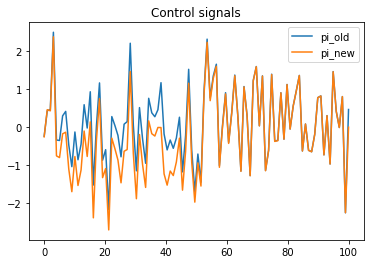

In [12]:
pi_new = update_control_signal(pi, trajectory, K, k)

%matplotlib inline
import matplotlib.pyplot as plt

t = np.linspace(0, T, T)
plt.plot(t, pi)
plt.plot(t, pi_new)
plt.title('Control signals')
plt.legend(['pi_old', 'pi_new'])

## Full loop

In [13]:
converged = False
new_simulation = True
render_env = False

pi = np.random.randn(T, 1)

while not converged:
    if new_simulation:
        trajectory, derivatives, cost = forward_pass(pi)
        new_simulation = False
    
    K, k = backward_pass(derivatives, lamb)
    
    pi_new = update_control_signal(pi, trajectory, K, k)
    
    new_trajectory, new_derivatives, new_cost = forward_pass(pi_new)

    print (np.abs(cost - new_cost)/cost)
    if new_cost < cost:
        lamb /= lamb_factor
    
        pi = pi_new
        trajectory = new_trajectory
        cost = new_cost
        
        new_simulation = True
        
        if (np.abs(cost - new_cost)/cost) < eps_converge:
            'Converged!'
            break
    else:
        lamb *= lamb_factor
        
        if lamb > lamb_max:
            print 'lamb > lamb_max. Dit not converge!'
            break;

[ 0.39178291]
[ 0.15873113]
[ 0.14733809]
[ 0.13543451]
